# Preprocessing and Modeling CTR Prediction - Filtering the device id with highest presence

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading Dataset and New Time Features

In [2]:
# Reading file (train_shuffled_with_columns.csv is result of shuffling the original train.csv file)
dataset = r'train_shuffled.csv' 
df = pd.read_csv(dataset,nrows=5000000)

# Rename column 'hour' to 'timestamp'
df.rename(columns={'hour':'timestamp'}, inplace=True)

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d%H')

# Sorting rows per 'hour'
df = df.sort_values(by='timestamp')
df.head(2)

,id,click,timestamp,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
406136,9620681124928476074,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,54c5d545,2347f47a,...,1,0,6560,320,50,571,2,39,-1,32
3905068,11124481820735373480,0,2014-10-21,1005,0,6399eda6,968765cd,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100081,23


In [3]:
# Creating new features

# time related features
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d') # yyyy-mm-dd
df['day_of_week'] = df['timestamp'].dt.dayofweek # 0: monday... 6: sunday
df['hour'] = df['timestamp'].dt.hour # 0-23

# num_impressions_user_day: Number of impressions a user (device_id) has in a day
df['num_impressions_user_day'] = df.groupby(['date', 'device_id'])['id'].transform('count')

# time_interval_last_visit: Time interval from the last visit
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['device_id', 'timestamp'], inplace=True)
df['time_interval_last_visit'] = df.groupby('device_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# num_days_user_appears: Number of days the user appeared
df['num_days_user_appears'] = df.groupby('device_id')['date'].transform('nunique')

# num_previous_clicks: number of clicks the user has done 
df['num_previous_clicks'] = df.groupby('device_id')['click'].cumsum() - df['click']

print('new features created')

new features created


#### Inspecting device_id

In [4]:
# Grouping by 'device_id' and aggregating
df_user = df.groupby('device_id').agg(
    sum_device_id=('device_id', 'count'),  # Sum of device_id occurrences
    sum_device_ip=('device_ip', 'nunique'),  # Counting unique device_ip
    sum_timestamp=('timestamp', 'nunique'),  # Counting unique timestamp
    click_0=('click', lambda x: (x == 0).sum()),  # Counting zeros in 'click'
    click_1=('click', lambda x: (x == 1).sum())  # Counting ones in 'click'
).reset_index()

# Sorting the DataFrame in descending order according to 'sum_device_ip'
df_user = df_user.sort_values(by='sum_device_id', ascending=False)

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Printing the sum of device_id
print("Sum of device_id:", df_user['sum_device_id'].sum())

print(df_user.head(10))

Sum of device_id: 5000000
       device_id  sum_device_id  sum_device_ip  sum_timestamp  click_0  \
397245  a99f214a        4125468        1532879            240  3407270   
36392   0f7c61dc           2627           2618             60      631   
457808  c357dbff           2434           2386             50      902   
345591  936e92fb           1678           1113            231     1583   
412174  afeffc18           1229            685            164      952   
357179  987552d1            569             25             88      569   
96199   28dc8687            518              1             43      518   
506978  d857ffbb            483            331            161      362   
484952  cef4c8cc            468            268            164      349   
413754  b09da1c4            437            230            142      388   

        click_1  
397245   718198  
36392      1996  
457808     1532  
345591       95  
412174      277  
357179        0  
96199         0  
506978      121

In [5]:
# Filtering out rows where 'sum_device_id' is greater than 10000
df = df[df['device_id'].isin(df_user[df_user['sum_device_id'] <= 10000]['device_id'])]

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Printing the sum of device_id
print("Sum of device_id:", df_user[df_user['sum_device_id'] <= 10000]['sum_device_id'].sum())

print(df.head(10))

Sum of device_id: 874532
                           id  click           timestamp    C1  banner_pos  \
4020225   4205289031887424560      0 2014-10-28 23:00:00  1002           0   
390129    4879883073788055735      0 2014-10-29 23:00:00  1002           0   
4908747  14542670317228439337      0 2014-10-22 08:00:00  1005           0   
953290   15792788417799490955      0 2014-10-22 01:00:00  1005           0   
1067525    888980563609895503      1 2014-10-28 14:00:00  1005           0   
4265850   7072066774785947847      0 2014-10-27 22:00:00  1005           0   
3879102  14324473564406995627      0 2014-10-23 10:00:00  1010           1   
663516   16628609526357650511      1 2014-10-29 08:00:00  1002           0   
441192   18171154887618280086      0 2014-10-21 21:00:00  1002           0   
2058997   6190042303393996177      0 2014-10-23 11:00:00  1005           0   

          site_id site_domain site_category    app_id app_domain  ...   C19  \
4020225  73747544    c4e18dd6      50

In [6]:
# Dropping columns 'id' and 'timestamp'
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
    print('column id was deleted')

if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)
    print('column timestamp was deleted')

column id was deleted
column timestamp was deleted


# Adressing imbalance problem: Downsampling majority class = 0

In [7]:
# Separate majority and minority classes
df_majority = df[df['click'] == 0]
df_minority = df[df['click'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the DataFrame
df = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class counts
print(df['click'].value_counts())

click
1    130547
0    130547
Name: count, dtype: int64


In [8]:
# Summary of Number of unique values and data type per column
summary = pd.DataFrame(df.nunique(), columns=['num_unique'])
summary['dtype'] = df.dtypes
summary

,num_unique,dtype
click,2,int64
C1,7,int64
banner_pos,5,int64
site_id,1443,object
site_domain,2328,object
site_category,5,object
app_id,2185,object
app_domain,183,object
app_category,26,object
device_id,218313,object


In [9]:
df.shape

(261094, 29)

In [10]:
variable_types = {
    'click': 'target',
    'C1': 'categorical nominal to encode',
    'banner_pos': 'categorical ready to use',
    'site_id': 'categorical nominal to encode',
    'site_domain': 'categorical nominal to encode',
    'site_category': 'categorical nominal to encode',
    'app_id': 'categorical nominal to encode',
    'app_domain': 'categorical nominal to encode',
    'app_category': 'categorical nominal to encode',
    'device_id': 'categorical nominal to encode',
    'device_ip': 'categorical nominal to encode',
    'device_model': 'categorical nominal to encode',
    'device_type': 'categorical ready to use',
    'device_conn_type': 'categorical ready to use',
    'C14': 'categorical nominal to encode',
    'C15': 'categorical ready to use',
    'C16': 'categorical ready to use',
    'C17': 'categorical ready to use',
    'C18': 'categorical ready to use',
    'C19': 'categorical ready to use',
    'C20': 'categorical nominal to encode', # Most popular label is '-1' and the others have a format like this '100098'
    'C21': 'categorical ready to use',
    'date': 'categorical ordinal to encode',
    'day_of_week': 'categorical ordinal to encode',
    'hour': 'categorical ready to use',
    'num_impressions_user_day': 'numerical',
    'time_interval_last_visit': 'numerical',
    'num_days_user_appears': 'numerical',
    'num_previous_clicks': 'numerical'
}

In [11]:
def check_repeated_counts(counts_dict):
    """
    Function to check for repeated count values in a counts dictionary.
    
    Args:
    counts_dict (dict): A dictionary where the keys are the categories and the values are the counts.
    
    Returns:
    bool: True if there are repeated counts, False otherwise.
    """
    unique_counts = set(counts_dict.values())
    return len(unique_counts) != len(counts_dict)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

def power_of_2(x):
    if x > 6000:
        return (2 ** (int(np.log2(x)) - 13))
    elif x > 500:
        return (2 ** (int(np.log2(x)) - 5))
    elif x > 100:
        return (2 ** (int(np.log2(x)) - 2))
    else:
        return (2 ** (int(np.log2(x))))


def encode_categorical_column(column, column_type, n_features=None):
    """
    Encode a single categorical column based on its type.

    Args:
    column (Series): The Series containing the categorical data.
    column_type (str): The type of the column.
    n_features (int, optional): The number of features for feature hashing.

    Returns:
    Series: The encoded categorical column.
    """
    encoded_column = column.copy()
    
    if column_type == 'categorical ordinal to encode':
        # Apply label encoding
        label_encoder = LabelEncoder()
        encoded_column = label_encoder.fit_transform(encoded_column)
        print(f"Column {column.name} has been encoded with method: Label encoding")
    elif column_type == 'categorical nominal to encode':
        # Check for repeated counts
        counts_dict = column.value_counts().to_dict()
        repeated_counts = check_repeated_counts(counts_dict)
        if not repeated_counts:
            # Apply count frequency encoding
            encoded_column = column.map(column.value_counts())
            print(f"Column {column.name} has been encoded with method: Count Encoding")
        else:
            # Apply feature hashing
            if n_features is None:
                # Calculate the nearest power of 2 less than the number of unique values
                n_features = power_of_2(len(column.unique()))
                n_features = int(n_features)  # Convert to integer
                print(f"Column {column.name} will be encoded with method: Feature Hashing with n_features={n_features}")
            # Convert each element in the column to a string and wrap it in a list
            column_strings = column.astype(str).apply(lambda x: [x])
            hasher = FeatureHasher(n_features=n_features, input_type='string')
            hashed_features = hasher.fit_transform(column_strings)
            encoded_column = pd.Series(hashed_features.toarray().tolist())
            print(f"Column {column.name} has been encoded with method: Feature Hashing")
    else:
        raise ValueError("Invalid column type. Must be 'categorical ordinal to encode' or 'categorical nominal to encode'.")
    
    return encoded_column

In [13]:
# Create a new DataFrame to store the encoded columns
df_encoded = pd.DataFrame()

# Iterate over each column in the original DataFrame
for column_name, column_type in variable_types.items():
    # Check if the column needs encoding
    if column_type in ['categorical ordinal to encode', 'categorical nominal to encode']:
        # Encode the column
        encoded_column = encode_categorical_column(df[column_name], column_type)
        # Add the encoded column to the new DataFrame
        df_encoded[column_name] = encoded_column
    else:
        # For non-categorical columns, simply copy them to the new DataFrame
        df_encoded[column_name] = df[column_name]

# Display the encoded DataFrame
print('df was encoded successfully')

Column C1 has been encoded with method: Count Encoding
Column site_id will be encoded with method: Feature Hashing with n_features=32
Column site_id has been encoded with method: Feature Hashing
Column site_domain will be encoded with method: Feature Hashing with n_features=64
Column site_domain has been encoded with method: Feature Hashing
Column site_category will be encoded with method: Feature Hashing with n_features=4
Column site_category has been encoded with method: Feature Hashing
Column app_id will be encoded with method: Feature Hashing with n_features=64
Column app_id has been encoded with method: Feature Hashing
Column app_domain will be encoded with method: Feature Hashing with n_features=32
Column app_domain has been encoded with method: Feature Hashing
Column app_category will be encoded with method: Feature Hashing with n_features=16
Column app_category has been encoded with method: Feature Hashing
Column device_id will be encoded with method: Feature Hashing with n_fea

In [14]:
df_encoded.shape

(261094, 29)

### Splitting Features and Target

In [15]:
# Columns encoded with feature hashing and their respective n_features
columns_to_hash = {
    'site_id': 64,
    'site_domain': 64,
    'app_id': 64,
    'app_domain': 32,
    'app_category': 16,
    'device_id': 4,
    'device_ip': 16,
    'device_model': 128,
    'C14': 32,
    'C20': 32
}

# Function to apply feature hashing and one-hot encoding
def flatten_categorical(df, column, n_features):
    # Apply feature hashing
    hashed_features = df[column].apply(lambda x: hash(str(x)) % n_features)
    
    # Convert hashed features into binary columns using one-hot encoding
    one_hot_encoded = pd.get_dummies(hashed_features, prefix=column)
    
    return one_hot_encoded

# Flatten categorical variables using feature hashing and one-hot encoding
flattened_categorical = []
for column, n_features in columns_to_hash.items():
    flattened_categorical.append(flatten_categorical(df_encoded, column, n_features))

# Concatenate flattened categorical variables with the original dataframe
df_encoded_flattened = pd.concat([df_encoded] + flattened_categorical, axis=1)

# Remove original categorical columns
df_encoded_flattened.drop(columns=columns_to_hash.keys(), inplace=True)

# Display the resulting dataframe
print(df_encoded_flattened.head())


   click      C1  banner_pos          site_category  device_type  \
0      1  135711           0  [-1.0, 0.0, 0.0, 0.0]            1   
1      0   95182           0  [-1.0, 0.0, 0.0, 0.0]            0   
2      1   95182           0  [-1.0, 0.0, 0.0, 0.0]            0   
3      0   28302           1  [-1.0, 0.0, 0.0, 0.0]            5   
4      1  135711           0  [-1.0, 0.0, 0.0, 0.0]            1   

   device_conn_type  C15  C16   C17  C18  ...  C20_21  C20_22  C20_23  C20_24  \
0                 0  320   50   178    3  ...   False   False   False   False   
1                 0  320   50  2684    2  ...   False   False    True   False   
2                 0  320   50  2684    2  ...   False   False   False   False   
3                 0  320   50  2513    3  ...   False   False   False   False   
4                 0  320   50  2374    3  ...   False   False   False   False   

   C20_25  C20_27  C20_28  C20_29  C20_30  C20_31  
0    True   False   False   False   False   False  


In [16]:
# Separate features and target
X = df_encoded_flattened.drop('click', axis=1)  # Features
y = df_encoded_flattened['click']  # Target

# LR-TruncatedSVD

In [17]:
# TruncatedSVD for dimensionality reduction on sparse input
from sklearn.decomposition import TruncatedSVD

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Fit and transform the sparse data
X_svd = svd.fit_transform(X)

# Create a new DataFrame with the principal components
df_svd = pd.DataFrame(data=X_svd, columns=['PC1', 'PC2'])

# Concatenate the principal components DataFrame with the target variable
df_svd['click'] = df_downsampled['click'].values

# Display the first few rows of the TruncatedSVD DataFrame
print(df_svd.head())

ValueError: setting an array element with a sequence.

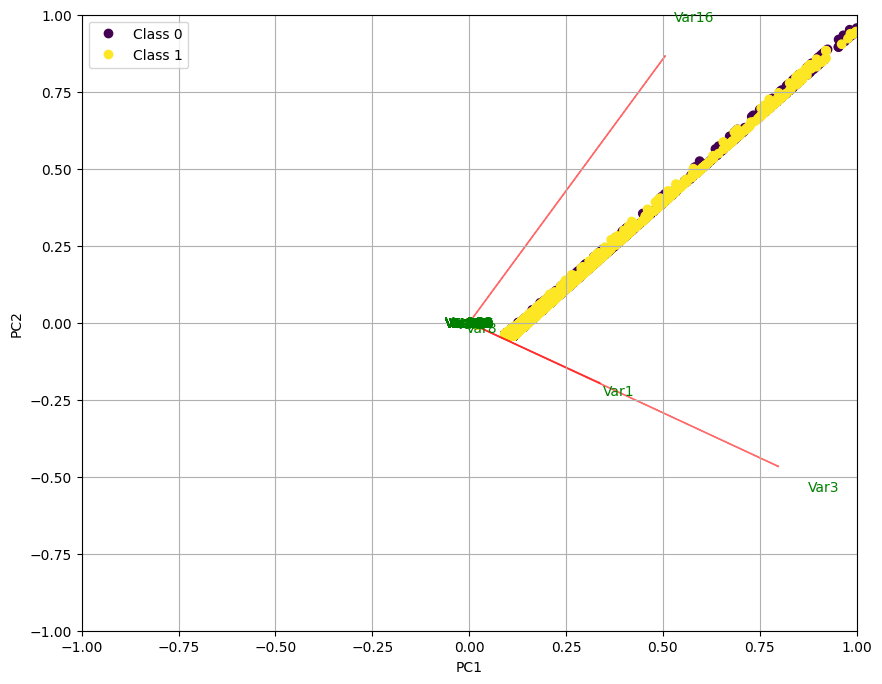

In [ ]:
import matplotlib.pyplot as plt

# Plot Biplot
def biplot_encoded(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    scatter = plt.scatter(xs * scalex, ys * scaley, c=df_svd['click'], cmap='viridis') 
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])

# Plotting the biplot using pre-calculated principal components
plt.figure(figsize=(10, 8))
biplot_encoded(df_svd[['PC1', 'PC2']].values, np.transpose(svd.components_[0:2, :]))
plt.show()

## Splitting data in training and test (After SVD)

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y , test_size=0.2, random_state=42)

## Splitting data in training and test (without SVD)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=42)

## LG (using features resulting from SVD)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score

# Fit logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_svd, y_train_svd)

# Predict probabilities
y_prob = logreg.predict_proba(X_test_svd)

# Compute log loss
logloss_LR_SVD = log_loss(y_test_svd, y_prob)
print("Log Loss LG-SVD:", logloss_LR_SVD)

# Confusion Matrix
y_pred = logreg.predict(X_test_svd)
cm = confusion_matrix(y_test_svd, y_pred)
print("Confusion Matrix LG-SVD:")
print(cm)

# Compute TPR and FPR
TN_LR_SVD, FP_LR_SVD, FN_LR_SVD, TP_LR_SVD = cm.ravel()
TPR_LR_SVD = TP_LR_SVD / (TP_LR_SVD + FN_LR_SVD)
FPR_LR_SVD = FP_LR_SVD / (FP_LR_SVD + TN_LR_SVD)
print("True Positive Rate (TPR) LG-SVD:", TPR_LR_SVD)
print("False Positive Rate (FPR) LG-SVD:", FPR_LR_SVD)

# Compute F1-Score
f1_LR_SVD = f1_score(y_test, y_pred)
print("F1-Score (LG-SVD):", f1_LR_SVD)

Log Loss LG-SVD: 0.6920905426730198
Confusion Matrix LG-SVD:
[[ 359 4862]
 [ 198 5033]]
True Positive Rate (TPR) LG-SVD: 0.962148728732556
False Positive Rate (FPR) LG-SVD: 0.931239226201877
F1-Score (LG-SVD): 0.6654766626999868


# Without SVD (LR + Regulatization)

### Standarizing x

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model with regularization
C = 0.5  # Regularization parameter
logreg_regularized = LogisticRegression(C=C, penalty='l2')
logreg_regularized.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob_regularized = logreg_regularized.predict_proba(X_test_scaled)

# Compute log loss
logloss_LR_regularized = log_loss(y_test, y_prob_regularized)
print("Log Loss (LR-Regularized):", logloss_LR_regularized)

# Confusion Matrix
y_pred_regularized = logreg_regularized.predict(X_test_scaled)
cm_regularized = confusion_matrix(y_test, y_pred_regularized)
print("Confusion Matrix (LR-Regularized):")
print(cm_regularized)

# Compute TPR and FPR
TN_reg, FP_reg, FN_reg, TP_reg = cm_regularized.ravel()
TPR_regularized = TP_reg / (TP_reg + FN_reg)
FPR_regularized = FP_reg / (FP_reg + TN_reg)
print("True Positive Rate (TPR) (LR-Regularized):", TPR_regularized)
print("False Positive Rate (FPR) (LR-Regularized):", FPR_regularized)

# Compute F1-Score
f1_LR_regularized = f1_score(y_test, y_pred_regularized)
print("F1-Score (LR-Regularized):", f1_LR_regularized)

Log Loss (LR-Regularized): 0.6405328123892404
Confusion Matrix (LR-Regularized):
[[3135 2086]
 [1769 3462]]
True Positive Rate (TPR) (LR-Regularized): 0.6618237430701587
False Positive Rate (FPR) (LR-Regularized): 0.3995403179467535
F1-Score (LR-Regularized): 0.6423601447258559


c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Without standarizing x

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import StandardScaler

# Fit logistic regression model with regularization
C = 0.5  # Regularization parameter
logreg_regularized_nostd = LogisticRegression(C=C, penalty='l2')
logreg_regularized_nostd.fit(X_train, y_train)

# Predict probabilities
y_prob_regularized_nostd = logreg_regularized_nostd.predict_proba(X_test)

# Compute log loss
logloss_LR_regularized_nostd = log_loss(y_test, y_prob_regularized_nostd)
print("Log Loss (LR-Regularized) No Standarized:", logloss_LR_regularized_nostd)

# Confusion Matrix
y_pred_regularized_nostd = logreg_regularized_nostd.predict(X_test)
cm_regularized_nostd = confusion_matrix(y_test, y_pred_regularized_nostd)
print("Confusion Matrix (LR-Regularized) No Standarized :")
print(cm_regularized_nostd)

# Compute TPR and FPR
TN_reg_nostd, FP_reg_nostd, FN_reg_nostd, TP_reg_nostd = cm_regularized_nostd.ravel()
TPR_regularized_nostd = TP_reg_nostd / (TP_reg_nostd + FN_reg_nostd)
FPR_regularized_nostd = FP_reg_nostd / (FP_reg_nostd + TN_reg_nostd)
print("True Positive Rate (TPR) (LR-Regularized) No Standarized:", TPR_regularized_nostd)
print("False Positive Rate (FPR) (LR-Regularized) No Standarized:", FPR_regularized_nostd)

# Compute F1-Score
f1_LR_regularized_nostd = f1_score(y_test, y_pred_regularized_nostd)
print("F1-Score (LR-Regularized) No Standarized:", f1_LR_regularized_nostd)

Log Loss (LR-Regularized) No Standarized: 0.6760452225584015
Confusion Matrix (LR-Regularized) No Standarized :
[[3457 1764]
 [2707 2524]]
True Positive Rate (TPR) (LR-Regularized) No Standarized: 0.48250812464155995
False Positive Rate (FPR) (LR-Regularized) No Standarized: 0.3378663091361808
F1-Score (LR-Regularized) No Standarized: 0.5303078054417482


c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict probabilities
y_prob_rf = rf_classifier.predict_proba(X_test)

# Compute log loss
logloss_rf = log_loss(y_test, y_prob_rf)
print("Log Loss (Random Forest):", logloss_rf)

# Confusion Matrix
y_pred_rf = rf_classifier.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Compute TPR and FPR
TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()
TPR_rf = TP_rf / (TP_rf + FN_rf)
FPR_rf = FP_rf / (FP_rf + TN_rf)
print("True Positive Rate (TPR) (Random Forest):", TPR_rf)
print("False Positive Rate (FPR) (Random Forest):", FPR_rf)

# Compute F1-Score
f1_rf = f1_score(y_test, y_pred_rf)
print("F1-Score (Random Forest):", f1_rf)

Log Loss (Random Forest): 0.6466854195589338
Confusion Matrix (Random Forest):
[[3414 1807]
 [1773 3458]]
True Positive Rate (TPR) (Random Forest): 0.6610590709233416
False Positive Rate (FPR) (Random Forest): 0.34610227925684733
F1-Score (Random Forest): 0.6589176829268292


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict probabilities
y_prob_xgb = xgb_classifier.predict_proba(X_test)

# Compute log loss
logloss_xgb = log_loss(y_test, y_prob_xgb)
print("Log Loss (XGBoost):", logloss_xgb)

# Confusion Matrix
y_pred_xgb = xgb_classifier.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)

# Compute TPR and FPR
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TPR_xgb = TP_xgb / (TP_xgb + FN_xgb)
FPR_xgb = FP_xgb / (FP_xgb + TN_xgb)
print("True Positive Rate (TPR) (XGBoost):", TPR_xgb)
print("False Positive Rate (FPR) (XGBoost):", FPR_xgb)

# Compute F1-Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print("F1-Score (XGBoost):", f1_xgb)

Log Loss (XGBoost): 0.610570309899833
Confusion Matrix (XGBoost):
[[3284 1937]
 [1585 3646]]
True Positive Rate (TPR) (XGBoost): 0.696998661823743
False Positive Rate (FPR) (XGBoost): 0.3710017238076997
F1-Score (XGBoost): 0.6743110782319216


# Feed Forward Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model_fnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model_fnn.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", accuracy)

# Predict probabilities on test set
y_pred_probs = model_fnn.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate log loss
logloss_fnn = log_loss(y_test, y_pred_probs)
print("Log Loss FNN:", logloss_fnn)

# Confusion Matrix
cm_fnn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix FNN:")
print(cm_fnn)

# Compute TPR and FPR
TN_fnn, FP_fnn, FN_fnn, TP_fnn = cm_fnn.ravel()
TPR_fnn = TP_fnn / (TP_fnn + FN_fnn)
FPR_fnn = FP_fnn / (FP_fnn + TN_fnn)
print("True Positive Rate (TPR) (FNN):", TPR_fnn)
print("False Positive Rate (FPR) (FNN):", FPR_fnn)

# Calculate F1-score
f1_fnn = f1_score(y_test, y_pred)
print("F1-score FNN:", f1_fnn)

Epoch 1/10
1176/1176 [==============================] - 3s 2ms/step - loss: 0.6517 - accuracy: 0.6142 - val_loss: 0.6405 - val_accuracy: 0.6135
Epoch 2/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.6172 - accuracy: 0.6566 - val_loss: 0.6373 - val_accuracy: 0.6190
Epoch 3/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.5994 - accuracy: 0.6742 - val_loss: 0.6434 - val_accuracy: 0.6216
Epoch 4/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.5818 - accuracy: 0.6887 - val_loss: 0.6544 - val_accuracy: 0.6259
Epoch 5/10
1176/1176 [==============================] - 2s 1ms/step - loss: 0.5635 - accuracy: 0.7061 - val_loss: 0.6639 - val_accuracy: 0.6077
Epoch 6/10
1176/1176 [==============================] - 2s 1ms/step - loss: 0.5463 - accuracy: 0.7153 - val_loss: 0.6811 - val_accuracy: 0.6176
Epoch 7/10
1176/1176 [==============================] - 2s 2ms/step - loss: 0.5287 - accuracy: 0.7325 - val_loss: 0.7068 - val_accuracy:

# NAFM (Neural Additive Factorization Model)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score

# Build the NAFM model
model_nafm = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nafm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

# Train the model
model_nafm.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy, auc = model_nafm.evaluate(X_test_scaled, y_test)
print("Test Accuracy NAFM:", accuracy)

# Predict probabilities on test set
y_pred_probs = model_nafm.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate log loss
logloss_nafm = log_loss(y_test, y_pred_probs)
print("Log Loss NAFM:", logloss_nafm)

# Confusion Matrix
cm_nafm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix NAFM:")
print(cm_nafm)

# Compute TPR and FPR
TN_nafm, FP_nafm, FN_nafm, TP_nafm = cm_nafm.ravel()
TPR_nafm = TP_nafm / (TP_nafm + FN_nafm)
FPR_nafm = FP_nafm / (FP_nafm + TN_nafm)
print("True Positive Rate (TPR) (NAFM):", TPR_nafm)
print("False Positive Rate (FPR) (NAFM):", FPR_nafm)

# Calculate F1-score
f1_nafm = f1_score(y_test, y_pred)
print("F1-score NAFM:", f1_nafm)

Epoch 1/5
1176/1176 [==============================] - 3s 2ms/step - loss: 0.6595 - accuracy: 0.6041 - auc: 0.6484 - val_loss: 0.6435 - val_accuracy: 0.6211 - val_auc: 0.6776
Epoch 2/5
1176/1176 [==============================] - 2s 2ms/step - loss: 0.6224 - accuracy: 0.6495 - auc: 0.7071 - val_loss: 0.6348 - val_accuracy: 0.6348 - val_auc: 0.6901
Epoch 3/5
1176/1176 [==============================] - 2s 2ms/step - loss: 0.6074 - accuracy: 0.6656 - auc: 0.7283 - val_loss: 0.6371 - val_accuracy: 0.6305 - val_auc: 0.6887
Epoch 4/5
1176/1176 [==============================] - 2s 1ms/step - loss: 0.5951 - accuracy: 0.6764 - auc: 0.7433 - val_loss: 0.6463 - val_accuracy: 0.6243 - val_auc: 0.6781
Epoch 5/5
327/327 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.6386 - auc: 0.6886
Test Accuracy NAFM: 0.6386337280273438
327/327 [==============================] - 0s 889us/step
Log Loss NAFM: 0.6448594481501695
Confusion Matrix NAFM:
[[3263 1958]
 [1819 3412]]
True Po

# Feature Importance

In [ ]:
import numpy as np

def calculate_feature_importance(model, X):
    """
    Calculate feature importance based on the absolute weights of the connections between
    input features and the hidden layers of the given model.

    Parameters:
    - model: Trained machine learning model (e.g., neural network)
    - X: Input features (numpy array or pandas DataFrame)

    Returns:
    - feature_importance: Dictionary containing feature names and their importance scores
    """

    # Extracting the weights of the first layer (assuming the model is sequential)
    first_layer_weights = model.layers[0].get_weights()[0]

    # Calculate the absolute sum of weights for each feature
    feature_importance_scores = np.abs(first_layer_weights).sum(axis=1)

    # Get feature names (if X is a DataFrame)
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        # Assuming feature names are not available
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # Create a dictionary to store feature importance scores
    feature_importance = dict(zip(feature_names, feature_importance_scores))

    # Sort feature importance scores in descending order
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

    return feature_importance


In [ ]:
feature_importance_nafm = calculate_feature_importance(model_nafm, X_test)

# Print feature importance scores
print('Feature Importance NAFM')
for feature, importance in feature_importance_nafm.items():
    print(f"Feature: {feature}, Importance Score: {importance}")

Feature Importance NAFM
Feature: C17, Importance Score: 5.421464920043945
Feature: num_days_user_appears, Importance Score: 5.169361114501953
Feature: C21, Importance Score: 4.71877384185791
Feature: num_previous_clicks, Importance Score: 4.4316582679748535
Feature: app_id_18, Importance Score: 4.2665019035339355
Feature: site_domain_8, Importance Score: 4.1876935958862305
Feature: site_id_48, Importance Score: 3.9986042976379395
Feature: C14_17, Importance Score: 3.9124064445495605
Feature: site_id_58, Importance Score: 3.8774991035461426
Feature: device_type, Importance Score: 3.796710968017578
Feature: C20_27, Importance Score: 3.7576050758361816
Feature: app_id_30, Importance Score: 3.747617721557617
Feature: app_id_6, Importance Score: 3.7373056411743164
Feature: app_id_49, Importance Score: 3.7185254096984863
Feature: app_id_13, Importance Score: 3.700251817703247
Feature: device_ip_11, Importance Score: 3.6437556743621826
Feature: site_domain_51, Importance Score: 3.643668889999

In [ ]:
feature_importance_fnn = calculate_feature_importance(model_fnn, X_test)

# Print feature importance scores
print('Feature Importance FNN')
for feature, importance in feature_importance_fnn.items():
    print(f"Feature: {feature}, Importance Score: {importance}")

Feature Importance FNN
Feature: app_category_8, Importance Score: 12.917848587036133
Feature: num_days_user_appears, Importance Score: 12.539371490478516
Feature: app_domain_13, Importance Score: 12.092540740966797
Feature: app_domain_28, Importance Score: 12.011364936828613
Feature: C17, Importance Score: 11.699041366577148
Feature: app_category_15, Importance Score: 11.501194953918457
Feature: C14_17, Importance Score: 11.389779090881348
Feature: device_type, Importance Score: 10.485865592956543
Feature: device_conn_type, Importance Score: 10.242281913757324
Feature: hour, Importance Score: 10.067256927490234
Feature: C18, Importance Score: 9.703704833984375
Feature: date, Importance Score: 9.636919021606445
Feature: app_category_7, Importance Score: 9.493183135986328
Feature: C20_21, Importance Score: 9.481233596801758
Feature: app_id_54, Importance Score: 9.395594596862793
Feature: C14_15, Importance Score: 9.314224243164062
Feature: site_domain_8, Importance Score: 9.2808895111083

In [ ]:
# Feature importance for logistic regression model

def calculate_feature_importance_logistic_regression(model, X):
    """
    Calculate feature importance based on the coefficients of a logistic regression model.

    Parameters:
    - model: Trained logistic regression model
    - X: Input features (numpy array or pandas DataFrame)

    Returns:
    - feature_importance: Dictionary containing feature names and their coefficients
    """

    # Get coefficients from the logistic regression model
    coefficients = model.coef_[0]

    # Get feature names (if X is a DataFrame)
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        # Assuming feature names are not available
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # Create a dictionary to store feature importance scores
    feature_importance = dict(zip(feature_names, coefficients))

    # Sort feature importance scores based on coefficients
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

    return feature_importance

In [ ]:
feature_importance_logreg = calculate_feature_importance_logistic_regression(logreg, X_test)

# Print feature importance scores
print('Feature Importance Logistic Regression')
for feature, coefficient in feature_importance_logreg.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature Importance Logistic Regression
Feature: C1, Coefficient: -7.038663731800038e-07
Feature: banner_pos, Coefficient: -1.7265584505895658e-06


# Summary (Original)

In [ ]:
import pandas as pd

# Initialize an empty list to store model outcomes
model_outcomes_data = []

# Add logistic regression outcomes with SVD
model_outcomes_data.append({'Model': 'Logistic Regression + SVD',
                            'Log Loss': logloss_LR_SVD,
                            'TPR': TPR_LR_SVD,
                            'FPR': FPR_LR_SVD,
                            'F1-Score': f1_LR_SVD})

# Add logistic regression outcomes without PCA, with regularization
#model_outcomes_data.append({'Model': 'Logistic Regression + Regularization',
#                            'Log Loss': logloss_LR_regularized,
#                            'TPR': TPR_regularized,
#                            'FPR': FPR_regularized,
#                            'F1-Score': f1_LR_regularized})

# Add logistic regression without SVD, with regularization, No standarized inputs
model_outcomes_data.append({'Model': 'Logistic Regression + Regularization (No Standarized)',
                            'Log Loss': logloss_LR_regularized_nostd,
                            'TPR': TPR_regularized_nostd,
                            'FPR': FPR_regularized_nostd,
                            'F1-Score': f1_LR_regularized_nostd})

# Add random forest outcomes
model_outcomes_data.append({'Model': 'Random Forest',
                            'Log Loss': logloss_rf,
                            'TPR': TPR_rf,
                            'FPR': FPR_rf,
                            'F1-Score': f1_rf})

# Add XGBoost outcomes
model_outcomes_data.append({'Model': 'XGBoost',
                            'Log Loss': logloss_xgb,
                            'TPR': TPR_xgb,
                            'FPR': FPR_xgb,
                            'F1-Score': f1_xgb})

# Add FNN outcomes
model_outcomes_data.append({'Model': 'Feedforward Neural Network',
                            'Log Loss': logloss_fnn,
                            'TPR': TPR_fnn,
                            'FPR': FPR_fnn,
                            'F1-Score': f1_fnn})

# Add NAFM outcomes
model_outcomes_data.append({'Model': 'Neural Attentive Factorization Machine',
                            'Log Loss': logloss_nafm,
                            'TPR': TPR_nafm,
                            'FPR': FPR_nafm,
                            'F1-Score': f1_nafm})

# Create a DataFrame from the list of model outcomes
model_outcomes = pd.DataFrame(model_outcomes_data)

# Display the table
print(model_outcomes)

                                               Model  Log Loss       TPR  \
0                          Logistic Regression + SVD  0.692091  0.962149   
1  Logistic Regression + Regularization (No Stand...  0.676045  0.482508   
2                                      Random Forest  0.646685  0.661059   
3                                            XGBoost  0.610570  0.696999   
4                         Feedforward Neural Network  0.736680  0.631810   
5             Neural Attentive Factorization Machine  0.644859  0.652265   

        FPR  F1-Score  
0  0.931239  0.665477  
1  0.337866  0.530308  
2  0.346102  0.658918  
3  0.371002  0.674311  
4  0.384026  0.627075  
5  0.375024  0.643713  
